# _Exploration: Jan. 9, 2020_

Following analysis is adapted from DataCamp's [Feature Engineering for NLP in Python](https://www.datacamp.com/courses/feature-engineering-for-nlp-in-python) program.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## _Load in Verified User Data_

In [3]:
# load in data
verified = pd.read_json("json-data/verified_train.json", orient="split", dtype={"id_str": str})
ira = pd.read_json("json-data/ira_train.json", orient="split", dtype={"id_str": str}).sample(n=len(verified), random_state=5)

# combine dfs above 
df = pd.concat([verified, ira])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337766 entries, 0 to 1353475
Data columns (total 10 columns):
id_str            337766 non-null object
screen_name       337766 non-null object
created_at        337766 non-null datetime64[ns]
lang              337766 non-null object
source            337766 non-null object
retweet_count     337766 non-null int64
favorite_count    337766 non-null int64
full_text         337766 non-null object
clean_text        337766 non-null object
label             337766 non-null object
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 28.3+ MB


In [5]:
# one hot encode label column
df = pd.get_dummies(df, columns=["label"])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337766 entries, 0 to 1353475
Data columns (total 11 columns):
id_str            337766 non-null object
screen_name       337766 non-null object
created_at        337766 non-null datetime64[ns]
lang              337766 non-null object
source            337766 non-null object
retweet_count     337766 non-null int64
favorite_count    337766 non-null int64
full_text         337766 non-null object
clean_text        337766 non-null object
label_fake        337766 non-null uint8
label_real        337766 non-null uint8
dtypes: datetime64[ns](1), int64(2), object(6), uint8(2)
memory usage: 26.4+ MB


## _Basic feature extraction_

In [7]:
# grab subset of data to experiment on
sample = df[["id_str", "screen_name", "created_at", "full_text", "label_fake", "label_real"]].sample(frac=0.50, random_state=5)

In [8]:
# reset index
sample.reset_index(drop=True, inplace=True)

In [9]:
# create a new column with character counts
sample["char_count"] = sample["full_text"].apply(len)

In [10]:
# first group by the labels then get average lenth
sample.groupby(["label_real"])["char_count"].mean()

label_real
0     80.650241
1    136.548233
Name: char_count, dtype: float64

In [11]:
def count_words(string):
    """
    Function that returns number of words in a string, and returns the number of words.
    """
    # split the string into words
    words = string.split()
    # return the number of words
    return len(words)

In [12]:
# create a new feature word_count
sample["word_count"] = sample["full_text"].apply(count_words)

# group by fake/real then pring average word count
sample.groupby("label_real")["word_count"].mean()

label_real
0    11.382623
1    19.993115
Name: word_count, dtype: float64

In [13]:
def count_hashtags(string):
    """
    Function that returns number of hashtags in a string
    """
    # split string into words
    words = string.split()
    # create a list of words that are hashtags
    hashtags = [word for word in words if word.startswith("#")]
    # return number of hashtags
    return len(hashtags)

In [14]:
# create new column with number of hashtags
sample["hashtag_count"] = sample["full_text"].apply(count_hashtags)

In [15]:
# group by fake/real and then return mean number of hashtags
sample.groupby("label_real")["hashtag_count"].mean()

label_real
0    0.659744
1    0.358038
Name: hashtag_count, dtype: float64

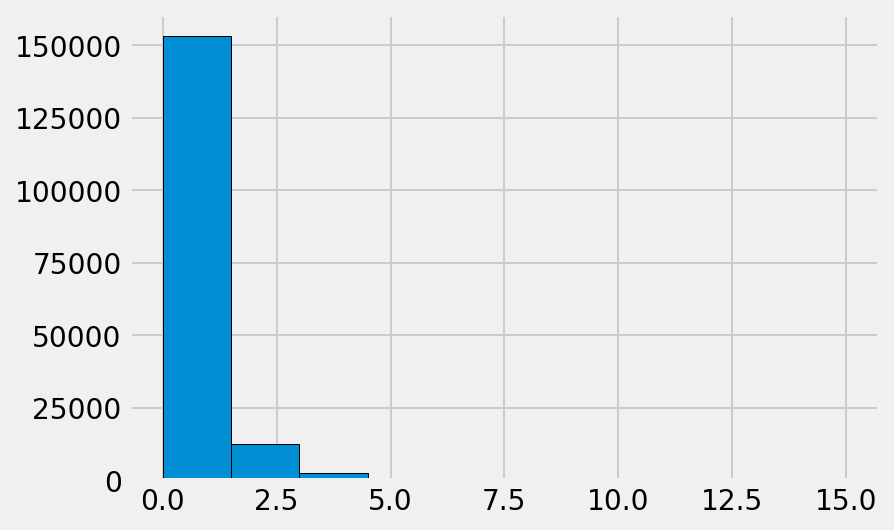

In [16]:
# plot the above
sample["hashtag_count"].hist(edgecolor="black");

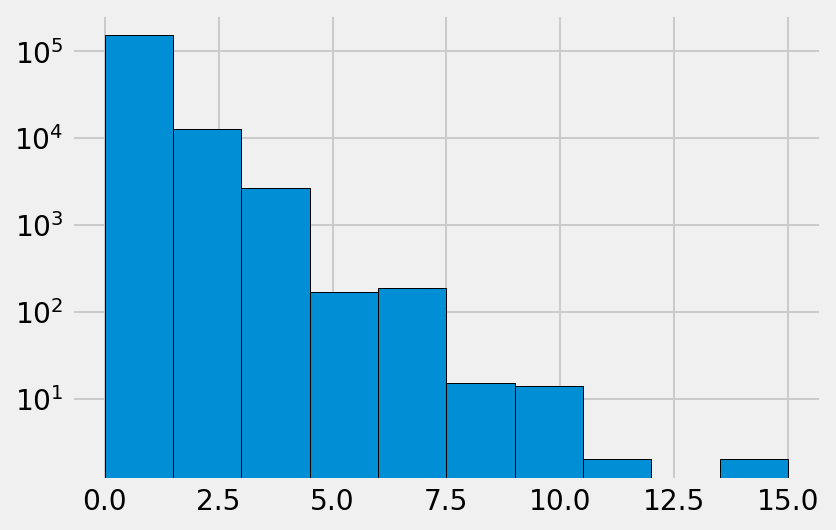

In [17]:
# same as the above but plotted on a logarithmic scale
sample["hashtag_count"].hist(edgecolor="black")
plt.yscale("log");

In [18]:
def count_mentions(string):
    """
    Function that returns number of mentions in a string
    """
    # split string into words
    words = string.split()
    # create list of words that are mentions
    mentions = [word for word in words if word.startswith("@")]
    # return number of mentions
    return len(mentions)

In [19]:
# create a column of mention counts
sample["mention_count"] = sample["full_text"].apply(count_mentions)

In [20]:
# group by fake/real and then return mean number of mentions
sample.groupby("label_real")["mention_count"].mean()

label_real
0    0.359735
1    0.493115
Name: mention_count, dtype: float64

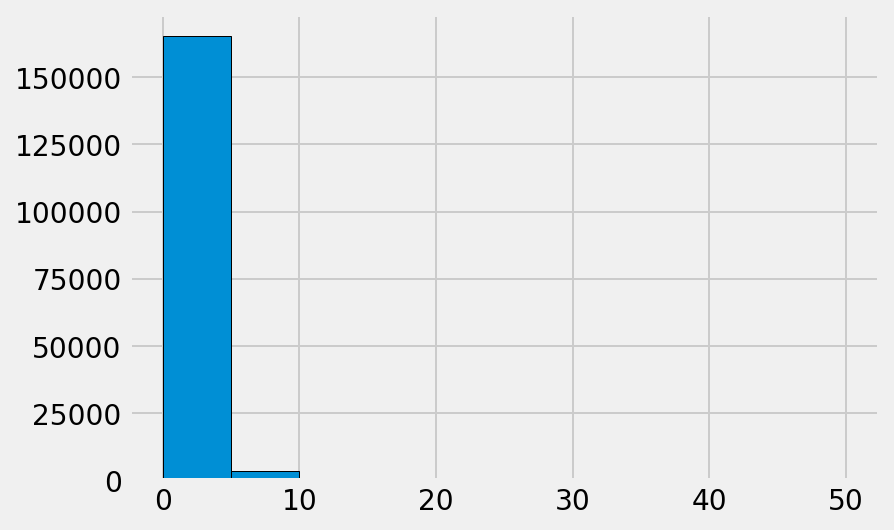

In [21]:
sample["mention_count"].hist(edgecolor="black");

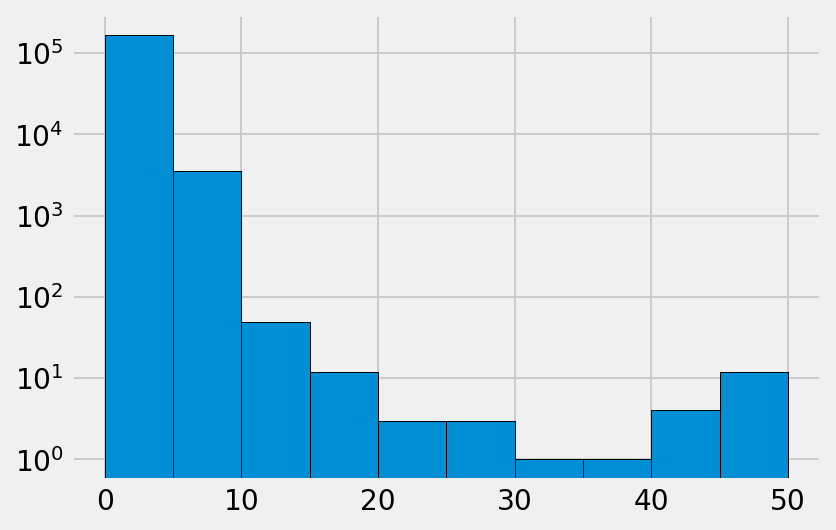

In [22]:
# same as above but with logarithmic yscale
sample["mention_count"].hist(edgecolor="black")
plt.yscale("log");

## _Notes_

- readability text examples
    - Flesch reading ease 
        - greater the average sentance length, harder the text is to read
        - greater the average number of syllables in a word, harder the text is to read
    - Gunning fog index
        - also dependent on average sentence length
        - greater the percentage of complex words, harder the text is to read
    - Simple Measure of Gobbledygook (SMOG)
    - Dale-Chall score

In [23]:
#!pip install textatistic

In [24]:
text = sample["full_text"][random.randint(0, len(sample))]
text

'.@SherylCrow, @TheBonnieRaitt and @mavisstaples. Three legends performing their new song together. That’s my kind of ladies’ night. https://t.co/GWv5cB8uzD'

In [25]:
from textatistic import Textatistic

# comput the readability score of random observation from data
readability_scores = Textatistic(text).scores

# print the flesch reading ease score
flesch = readability_scores["flesch_score"]
print("The Flesch Reading Ease is %.3f" % (flesch))

The Flesch Reading Ease is 71.581


In [26]:
random.seed(5)

# gather 4 random Tweets from sample subset
excerpts = list(random.sample(list(sample["full_text"]), k = 4))
excerpts

['Charles Schwab agrees to buy rival TD Ameritrade in a stock-swap transaction valued at about $26 billion https://t.co/mi3TIcjj4N',
 '|LIVE NOW| Ride wit me again http://t.co/B4lMBW5tXd',
 'Arizona man allegedly taught undercover FBI agents how to make bombs: reports https://t.co/pSn7bNEQdM',
 '@RichOnOWN @VisitOceanside so cool. I was just on set. Big scene with Lady Mae .\n #Greenleaf']

In [27]:
# loop through excerpts and computing Gunning Fog index
gunning_fog_scores = []

for excerpt in excerpts:
    scores = Textatistic(excerpt).scores
    gunning_fog = scores["gunningfog_score"]
    gunning_fog_scores.append(gunning_fog)
    
for excerpt in list(zip(gunning_fog_scores, excerpts)):
    print(excerpt, "\n")

(13.915789473684212, 'Charles Schwab agrees to buy rival TD Ameritrade in a stock-swap transaction valued at about $26 billion https://t.co/mi3TIcjj4N') 

(2.8000000000000003, '|LIVE NOW| Ride wit me again http://t.co/B4lMBW5tXd') 

(11.353846153846156, 'Arizona man allegedly taught undercover FBI agents how to make bombs: reports https://t.co/pSn7bNEQdM') 

(2.0, '@RichOnOWN @VisitOceanside so cool. I was just on set. Big scene with Lady Mae .\n #Greenleaf') 



## _Text preprocessing, POS tagging and NER_

In [28]:
import spacy

# load the en_core_web_sm model
nlp = spacy.load("en_core_web_sm")

# grab random Tweet
rando = sample["full_text"].sample(n=1, random_state=202).iloc[0]

# create a Doc object
doc = nlp(rando)

# generate list of tokens
tokens = [token.text for token in doc]
print(tokens)

['@PolisForCO', 'I', 'can', 'assure', 'Mr.', 'Polis', 'that', 'National', 'Guard', 'troops', 'from', 'Colorado', 'have', 'served', 'in', 'Afghanistan', 'and', 'Iraq', '.']


In [29]:
# generate list of lemmas
lemmas = [token.lemma_ for token in doc]
print(lemmas)

['@polisforco', '-PRON-', 'can', 'assure', 'Mr.', 'Polis', 'that', 'National', 'Guard', 'troop', 'from', 'Colorado', 'have', 'serve', 'in', 'Afghanistan', 'and', 'Iraq', '.']


In [30]:
# convert lemmas into a string
print(" ".join(lemmas))

@polisforco -PRON- can assure Mr. Polis that National Guard troop from Colorado have serve in Afghanistan and Iraq .


## _Text Cleaning Techniques_

- Unnecessary whitespaces and escape sequences
- punctuations
- special characters (numbers, emojis, etc.)
- stopwords
- `isalpha()` --> returns True if all characters of string are alphabetical
    - not nuanced

In [31]:
"dog".isalpha()

True

In [32]:
"3dog".isalpha()

False

In [33]:
import nltk

# access Donald Trump's inauguration speech from 2017
path = nltk.data.find("corpora/inaugural/2017-Trump.txt")
raw = open(path, 'r').read()

In [34]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# create Doc object
doc = nlp(raw)

# generate lemmatized tokens
lemmas = [token.lemma_ for token in doc]

# remove stopwords and non-alphabetic tokens
a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stopwords]

# print string after text cleaning
print(" ".join(a_lemmas))

Chief Justice Roberts President Carter President Clinton President Bush President Obama fellow Americans people world thank citizen America join great national effort rebuild country restore promise people determine course America world year come face challenge confront hardship job year gather step carry orderly peaceful transfer power grateful President Obama First Lady Michelle Obama gracious aid transition magnificent thank today ceremony special meaning today merely transfer power administration party transfer power Washington DC people long small group Nation capital reap reward Government people bear cost Washington flourish people share wealth politician prosper job leave factory close establishment protect citizen country victory victory triumph triumph celebrate Nation capital little celebrate struggle family land change start right right moment moment belong belong gather today watch America day celebration United States America country truly matter party control Government 

In [35]:
def preprocess(text):
    """
    Function to preprocess text.
    """
    # create Doc object
    doc = nlp(text, disable=["ner", "parser"])
    # generate lemmas
    lemmas = [token.lemma_ for token in doc]
    # remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stopwords]
    
    return " ".join(a_lemmas)

In [36]:
# apply the above to the first 10 observations in our sample data
for text in list(sample["full_text"][:10].apply(preprocess)):
    print(text)

old polar bear Klondike die age environment
politic Trump win Hawaii GOP caucus
true story
expect kickass sadly happen XD
belive
memorial night G
Jogging workout sampe malam
People ask positive time answer simple positive mindset bring positive result want result let gooooooooo people
local official react El Paso Children Hospital filing bankruptcy protection news
gossip gossip like cycle end


## _Part-of-speech (POS) tagging_

- word-sense disambiguation
- helps identifying why the word is being used
- sentiment analysis
- question answering
- has applications in fake news
- assign every word/token its corresponding part of speech

In [39]:
# store entire sample column into a variable
twitter_text = sample["full_text"]

In [41]:
# create a doc object of first tweet
doc = nlp(twitter_text[0])

# generate tokens and pos tags
pos = [(token.text, token.pos_) for token in doc]
print(pos)

[('Oldest', 'ADJ'), ('U.S.', 'PROPN'), ('polar', 'ADJ'), ('bear', 'NOUN'), ("'", 'PUNCT'), ('Klondike', 'PROPN'), ("'", 'PUNCT'), ('dies', 'VERB'), ('at', 'ADP'), ('age', 'NOUN'), ('34', 'NUM'), (' ', 'SPACE'), ('#', 'NOUN'), ('environment', 'NOUN')]


In [44]:
def proper_nouns(text, model=nlp):
    """
    Function that returns number of proper nouns.
    """
    doc = model(text)
    # generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # return number of proper nouns
    return pos.count("PROPN")

In [45]:
# call above function on first Twitter text observation
print(proper_nouns(twitter_text[0]))

2


In [46]:
def nouns(text, model=nlp):
    """
    Function that returns the number of other nouns.
    """
    # create doc object
    doc = model(text)
    # generate list of POS tags
    pos = [token.pos_ for token in doc]
    
    # return number of other nouns
    return pos.count("NOUN")

In [47]:
# call above function on first Twitter text observation
print(nouns(twitter_text[0]))

4


In [60]:
# create data frame of twitter text series (with labels)
textdf = sample[["full_text", "label_real"]].sample(frac=0.10, random_state=5)

In [61]:
len(textdf)

16888

In [63]:
%%time

# create a new column that returns number of propernouns from text
textdf["num_propn"] = textdf["full_text"].apply(proper_nouns)

CPU times: user 1min 56s, sys: 380 ms, total: 1min 56s
Wall time: 1min 57s


In [64]:
%%time

# create a new column that returns number of nouns from text
textdf["num_noun"] = textdf["full_text"].apply(nouns)

CPU times: user 1min 56s, sys: 341 ms, total: 1min 56s
Wall time: 1min 57s


In [66]:
# compute mean number of proper nouns
real_propn = textdf[textdf["label_real"] == 1]["num_propn"].mean()
fake_propn = textdf[textdf["label_real"] == 0]["num_propn"].mean()

# compute mean number of nouns 
real_noun = textdf[textdf["label_real"] == 1]["num_noun"].mean()
fake_noun = textdf[textdf["label_real"] == 0]["num_noun"].mean()

# Print results
print("Mean no. of proper nouns in real and fake tweets are %.2f and %.2f respectively"%(real_propn, fake_propn))
print("Mean no. of other nouns in real and fake tweets are %.2f and %.2f respectively"%(real_noun, fake_noun))

Mean no. of proper nouns in real and fake tweets are 3.24 and 2.36 respectively
Mean no. of other nouns in real and fake tweets are 4.21 and 3.06 respectively


### _Named entity recognition_

- efficient search algorithms
- question answering
- identifying and classifying named entities into predefined categories
- categories include person, organization, country, etc.

In [68]:
# data for quick example of NER
doc = nlp(twitter_text[0])

# generate named entities
ne = [(ent.text, ent.label_) for ent in doc.ents]
print(ne)

[('U.S.', 'GPE'), ('Klondike', 'WORK_OF_ART'), ('age 34', 'DATE')]


In [69]:
# Create a Doc instance 
text = 'Sundar Pichai is the CEO of Google. Its headquarters is in Mountain View.'
doc = nlp(text)

# Print all named entities and their labels
for ent in doc.ents:
    print(ent.text, ent.label_)

Sundar Pichai PERSON
Google ORG
Mountain View GPE


In [71]:
def find_persons(text):
    """
    Function that finds people in a given text.
    """
    doc = nlp(text)
    # identify the persons
    persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    return persons

In [72]:
print(find_persons(raw))

['Justice Roberts', 'Carter', 'Clinton', 'Bush', 'Obama', 'Michelle Obama', 'Bible', 'Creator', 'God']


### _Building a bag of words model_

- extract word tokens
- compute frequency of word tokens
- construct a word vector out of these frequencies and vocabulary of corpus

In [75]:
# reset index of textdf
textdf.reset_index(drop=True, inplace=True)

In [78]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# create CountVectorizer object
vectorizer = CountVectorizer()

# generate matrix of word vectors
bow_matrix = vectorizer.fit_transform(textdf["full_text"])

# print shape of bag-of-words matrix
print(bow_matrix.shape)

(16888, 39718)


In [81]:
# convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray())

# map the column names to vocabulary
bow_df.columns = vectorizer.get_feature_names()

# print first few row of first few columns
bow_df.iloc[:5, :10]

,00,000,000th,00qkfi5bhx,00quo5zvog,00y1sse2wp,01,0123456789,01dsic9v6c,01khwvpguu
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


### _Building a BOW Naive Bayes Classifier_

**Steps**
1. Text preprocessing
2. Building a bag-of-words model (i.e., representation)
3. Machine Learning

In [83]:
# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# split data
X_train, X_test, y_train, y_test = train_test_split(
    textdf["full_text"],
    textdf["label_real"],
    test_size=0.2,
    random_state=5
)

# create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True, stop_words="english")

# fit and transform X_train
X_train_bow = vectorizer.fit_transform(X_train)

# Transform X_test
X_test_bow = vectorizer.transform(X_test)

# print shape of X_train and X_test bows
print(X_train_bow.shape, X_test_bow.shape)

(13510, 33676) (3378, 33676)


In [84]:
from sklearn.naive_bayes import MultinomialNB

# create MultinomialNB object
clf = MultinomialNB()

# fit the classifier
clf.fit(X_train_bow, y_train)

# measure accuracy on test set
accuracy = clf.score(X_test_bow, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.801


In [85]:
# Predict whether the below text would come from a fake/real account
review = "Putin and Trump ROCK!"
prediction = clf.predict(vectorizer.transform([review]))[0]
print("The text was generated by a %i account" % (prediction))

The text was generated by a 0 account


### _Building n-gram models_

- shortcoming of bag of words --> context is lost
- n-grams --> contiguous sequence of _n_ elements (or words in a given document)
    - can capture more context
    - used in sentence completion, spelling correction, machine translation correction
    - curse of dimensionality
    - higher order n-grams are rare --> best when _n_ is small

In [90]:
# generates unigrams
unigrams = CountVectorizer(ngram_range=(1,1))
ng1 = unigrams.fit_transform(textdf["full_text"])

# generate up to bigrams
bigrams = CountVectorizer(ngram_range=(1,2))
ng2 = bigrams.fit_transform(textdf["full_text"])

# generates unigrams, bigrams and trigrams
ngrams = CountVectorizer(ngram_range=(1,3))
ng3 = ngrams.fit_transform(textdf["full_text"])

# Print the number of features for each model
print("ng1, ng2 and ng3 have %i, %i and %i features respectively" % (ng1.shape[1], ng2.shape[1], ng3.shape[1]))

ng1, ng2 and ng3 have 39718, 200425 and 418578 features respectively


In [99]:
# create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=False, stop_words="english", ngram_range=(1,2))

# fit and transform X_train
X_train_ng = vectorizer.fit_transform(X_train)

# Transform X_test
X_test_ng = vectorizer.transform(X_test)

# print shape of X_train and X_test bows
print(X_train_bow.shape, X_test_bow.shape)

(13510, 33676) (3378, 33676)


In [100]:
# define an instance of MultinomialNB
clf_ng = MultinomialNB()

# fit the classifier
clf_ng.fit(X_train_ng, y_train)

# measure the accuracy
accuracy = clf_ng.score(X_test_ng, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

The accuracy of the classifier on the test set is 0.809


In [101]:
# Predict if the following tweet is from a real or fake account
tweet = "The movie was not good. The plot had several holes and the acting lacked panache."
prediction = clf_ng.predict(vectorizer.transform([tweet]))[0]
print("The sentiment predicted by the classifier is %i" % (prediction))

The sentiment predicted by the classifier is 1


In [105]:
# comparing performance of n-gram models
import time

start_time = time.time()

# split data into train and test sets
train_X, test_X, train_y, test_y = train_test_split(
    textdf["full_text"],
    textdf["label_real"],
    test_size=0.5,
    stratify=textdf["label_real"],
    random_state=5
)

# generate ngrams
vectorizer = CountVectorizer(lowercase=False, stop_words="english", ngram_range=(1,1))
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

# fit classifier
clf = MultinomialNB()
clf.fit(train_X, train_y)

# Print accuracy, time and number of dimensions
print("""The program took %.3f seconds to complete. The accuracy on the test set is %.2f. The ngram 
representation had %i features.""" % (time.time() - start_time, clf.score(test_X, test_y), train_X.shape[1]))

The program took 0.347 seconds to complete. The accuracy on the test set is 0.80. The ngram 
representation had 28149 features.


In [106]:
# same as above but with ngrams up to 3
# comparing performance of n-gram models
import time

start_time = time.time()

# split data into train and test sets
train_X, test_X, train_y, test_y = train_test_split(
    textdf["full_text"],
    textdf["label_real"],
    test_size=0.5,
    stratify=textdf["label_real"],
    random_state=5
)

# generate ngrams
vectorizer = CountVectorizer(lowercase=False, stop_words="english", ngram_range=(1,3))
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

# fit classifier
clf = MultinomialNB()
clf.fit(train_X, train_y)

# Print accuracy, time and number of dimensions
print("""The program took %.3f seconds to complete. The accuracy on the test set is %.2f. The ngram 
representation had %i features.""" % (time.time() - start_time, clf.score(test_X, test_y), train_X.shape[1]))

The program took 1.039 seconds to complete. The accuracy on the test set is 0.79. The ngram 
representation had 177967 features.
